In [1]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # Updated tensorboard import [1]
import cv2
import ale_py
import gymnasium as gym
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class QNetwork(nn.Module):
    def __init__(self, frame_stack=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(frame_stack, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 6) 
        )


    def forward(self, x):
        x = x/255.0  # Normalize pixel values
        x = self.conv(x)
        return x

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state)  # Direct call instead of forward() [1]
            return torch.argmax(q_values).item()

class Memory(deque):  # Simplified memory implementation [1]
    def __init__(self, capacity):
        super().__init__(maxlen=capacity)

    def sample(self, batch_size):
        return random.sample(self, batch_size)



In [4]:
# Change environment creation
env = gym.make(
    "ALE/Pong-v5",
    frameskip=1,  # Equivalent to NoFrameskip
    repeat_action_probability=0.25,  # Disables action stickiness,
)
env = gym.wrappers.AtariPreprocessing(
    env,
    frame_skip=4,
    screen_size=84,
    terminal_on_life_loss=False
)
env = gym.wrappers.FrameStackObservation(env, 4)
n_state = env.observation_space.shape[0]

# Update network initialization
online_net = QNetwork(frame_stack=4).to(device)
target_net = QNetwork(frame_stack=4).to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.AdamW(online_net.parameters(), lr=1e-4)  # Modern optimizer [1]


In [6]:
BATCH_SIZE = 64
UPDATE_INTERVAL = 10
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01

learning_steps = 0
TIMESTEPS = 2000000
EPS_DECAY = 2000000 * 0.2

memory = Memory(100000)
writer = SummaryWriter('logs/dqn/pong_degraded')  # Updated tensorboard writer [1]

In [ ]:
epsilon = EPS_START
episode_reward = 0

for epoch in range(400):
    state, _ = env.reset()  # Updated reset unpacking [1]
    episode_reward = 0
    episode_length = 0
    # frame_stack.update(process_frame(state))

    for t in count():
        episode_length += 1
        # current_state = frame_stack.get()
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = online_net.select_action(state_tensor)

        # Updated step returns unpacking [1]
        next_state, reward, terminated, truncated, _ = env.step(action)
        # next_frame = process_frame(next_state)
        # frame_stack.update(next_frame)

        done = terminated or truncated
        episode_reward += reward
        memory.append((state, next_state, action, reward, done))

        if len(memory) >= BATCH_SIZE:
            # Experience replay
            transitions = memory.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            learning_steps += 1

            # Update target network
            if learning_steps % UPDATE_INTERVAL == 0:
                target_net.load_state_dict(online_net.state_dict())

            states = torch.tensor(np.array(batch[0]), dtype=torch.float32, device=device)
            next_states = torch.tensor(np.array(batch[1]), dtype=torch.float32, device=device)
            actions = torch.tensor(batch[2], dtype=torch.long, device=device).unsqueeze(1)
            rewards = torch.tensor(batch[3], dtype=torch.float32, device=device).unsqueeze(1)
            dones = torch.tensor(batch[4], dtype=torch.float32, device=device).unsqueeze(1)

            # Double DQN update
            with torch.no_grad():
                next_actions = online_net(next_states).argmax(1, keepdim=True)
                target_q = target_net(next_states).gather(1, next_actions)
                target = rewards + (1 - dones) * GAMMA * target_q

            current_q = online_net(states).gather(1, actions)
            loss = F.mse_loss(current_q, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epsilon > EPS_END:
                epsilon -= (EPS_START - EPS_END) / EPS_DECAY


        if done:
            break
        state = next_state

    writer.add_scalar('episode_reward', episode_reward, epoch)
    writer.add_scalar('episode_length', episode_length, epoch)

    if epoch % 10 == 0:
        torch.save(online_net.state_dict(), 'dqn-policy-pong.pt')  # Updated file extension [1]
        print(f'Epoch {epoch}: Reward {episode_reward:.2f}')


Epoch 0: Reward -21.00
Epoch 10: Reward -19.00
Epoch 20: Reward -21.00
Epoch 30: Reward -21.00
Epoch 40: Reward -18.00
Epoch 50: Reward -18.00
Epoch 60: Reward -18.00
Epoch 70: Reward -19.00
Epoch 80: Reward -20.00
Epoch 90: Reward -19.00
Epoch 100: Reward -18.00
Epoch 110: Reward -18.00
Epoch 120: Reward -15.00
Epoch 130: Reward -17.00
Epoch 140: Reward -20.00
Epoch 150: Reward -17.00
Epoch 160: Reward -19.00
Epoch 170: Reward -17.00
Epoch 180: Reward -19.00
Epoch 190: Reward -16.00
Epoch 200: Reward -17.00
Epoch 210: Reward -15.00
Epoch 220: Reward -15.00
Epoch 230: Reward -16.00
Epoch 240: Reward -12.00
Epoch 250: Reward -16.00
Epoch 260: Reward -11.00
Epoch 270: Reward -5.00
Epoch 280: Reward 1.00
Epoch 290: Reward -4.00
Epoch 300: Reward -7.00
Epoch 310: Reward -1.00
Epoch 320: Reward 7.00
Epoch 330: Reward 7.00
Epoch 340: Reward 7.00
Epoch 350: Reward 8.00
Epoch 360: Reward 11.00
Epoch 370: Reward 12.00
Epoch 380: Reward 10.00
Epoch 390: Reward 11.00
Epoch 400: Reward 7.00


KeyboardInterrupt: 

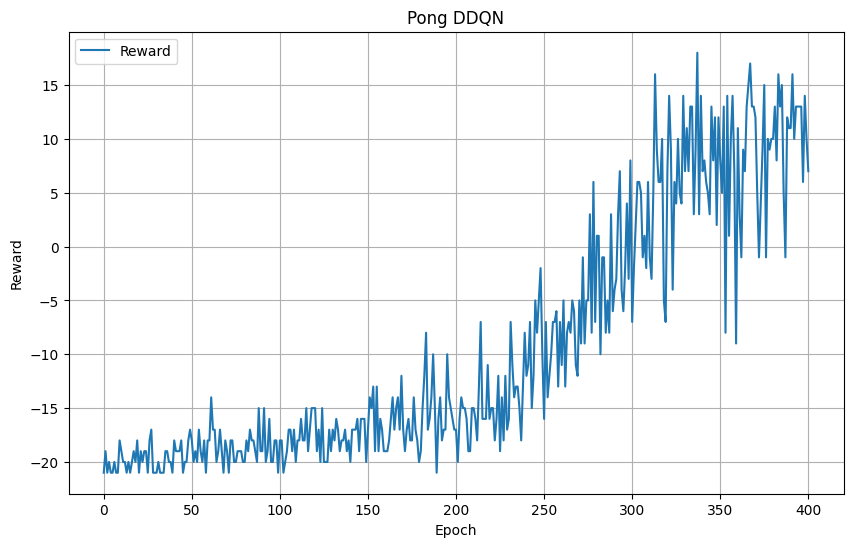

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt

# Load the TensorBoard log data
event_acc = EventAccumulator('logs/ddqn/pong')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards_ddqn = [event.value for event in reward_events]

event_acc = EventAccumulator('logs/dqn/pong_degraded')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards_dqn = [event.value for event in reward_events]

# apply moving average to smooth both the rewards
rewards_ddqn = np.convolve(rewards_ddqn, np.ones(10)/10, mode='valid')
rewards_dqn = np.convolve(rewards_dqn, np.ones(10)/10, mode='valid')



# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards_ddqn)), rewards_ddqn, label='DDQN Avg Reward (10)', color='blue')
plt.plot(range(len(rewards_dqn)), rewards_dqn, label='DQN Avg Reward (10)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Pong Reward vs. Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import imageio
import numpy as np

# Replace with your actual environment and trained model
env = gym.make(
    "ALE/Pong-v5",
    frameskip=1,  # Equivalent to NoFrameskip
    repeat_action_probability=0.25,
    render_mode="rgb_array",  # Set render mode to RGB array for image capture
)
env = gym.wrappers.AtariPreprocessing(
    env,
    frame_skip=4,
    screen_size=84,
    terminal_on_life_loss=False
)
env = gym.wrappers.FrameStackObservation(env, 4)
state, _ = env.reset()
frames = []

online_net.load_state_dict(torch.load('ddqn-policy-pong.pt'))

done = False
while not done:
    # Render the current frame
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = online_net.select_action(state_tensor)
    
    # Updated step returns unpacking [1]
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    frame = env.render()
    frames.append(frame)
    state = next_state

env.close()

# Save frames as GIF
imageio.mimsave("pong2.gif", frames, fps=30)
